# Bank Customer Churn Prediction Project

## Problem Understanding

In this project, the goal is to predict whether a bank customer will leave the bank (churn) or not based on their personal and account information.

This is a binary classification problem where:
- 1 means the customer has exited the bank.
- 0 means the customer is still a customer.

Before doing any analysis or feature engineering, it is important to split the dataset into training and test sets.  
This helps us avoid data leakage and ensures that the model is evaluated fairly.


In [27]:
#Importing essential libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


In [28]:
# Setting a random seed so results are reproducible
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Step 1: Load the Dataset

First, I loaded the dataset and checked its basic structure like number of rows, columns, and data types.
At this stage, I did not perform any preprocessing to make sure the test data remains unseen.


In [ ]:
data = pd.read_csv("Bank Customer Churn Prediction Assignment/Assignment_Tamanna_Yadav/dataset/Churn_Modelling.csv")

data.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [30]:
print("Dataset shape:", data.shape)
data.info()


Dataset shape: (10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Types of Features

From the dataset, the features can be broadly categorized as:

- Numerical Features: CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary
- Binary Features: HasCrCard, IsActiveMember
- Categorical Features: Geography, Gender, Surname
- Identifier Columns: RowNumber, CustomerId

Some columns like RowNumber, CustomerId, and Surname are not meaningful for prediction and will be removed later during feature selection.


### 1.2: Separate Features and Target Variable

The target variable in this dataset is `Exited`, which indicates whether the customer churned or not.

All other columns are treated as input features.


In [31]:
X = data.drop(columns=["Exited"])
y = data["Exited"]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (10000, 13)
Shape of y: (10000,)


### 1.3: Train-Test Split

I split the dataset into:
- 80% training data
- 20% test data

I used stratified sampling to ensure that the proportion of churned and non-churned customers remains similar in both training and test sets.

From this point onward, all feature engineering and model building will be done only on the training data.
The test set will be used only for final evaluation.


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

print("\nChurn distribution in full dataset:")
print(y.value_counts(normalize=True))

print("\nChurn distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nChurn distribution in test set:")
print(y_test.value_counts(normalize=True))


Training set shape: (8000, 13)
Test set shape: (2000, 13)

Churn distribution in full dataset:
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Churn distribution in training set:
Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64

Churn distribution in test set:
Exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64


# Part 2: Feature Engineering and Preprocessing

In this part, I performed preprocessing and feature engineering on the training data only.
This includes handling categorical variables, scaling numerical features, removing irrelevant columns, and creating new derived features.

The test data is intentionally kept untouched to avoid data leakage.


### 2.1: Feature Selection

Columns like RowNumber, CustomerId, and Surname do not carry predictive information about customer churn.
Therefore, they were removed from both training and test datasets.


In [33]:
# Copy train and test sets to avoid accidental modification
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# Drop irrelevant columns
drop_cols = ["RowNumber", "CustomerId", "Surname"]

X_train_fe.drop(columns=drop_cols, inplace=True)
X_test_fe.drop(columns=drop_cols, inplace=True)

print("Columns after dropping irrelevant features:")
print(X_train_fe.columns)


Columns after dropping irrelevant features:
Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


### 2.2: Feature Creation

A new feature called `Balance_per_Product` is created by dividing the account balance by the number of products owned by the customer.

This feature helps capture how much balance a customer maintains per product, which may provide additional insight into customer behavior.


In [34]:
# Encode Gender: Male = 1, Female = 0
X_train_fe["Gender"] = X_train_fe["Gender"].map({"Male": 1, "Female": 0})
X_test_fe["Gender"] = X_test_fe["Gender"].map({"Male": 1, "Female": 0})

print(X_train_fe["Gender"].value_counts())


Gender
1    4387
0    3613
Name: count, dtype: int64


### 2.3: Categorical Encoding

- Gender was converted into a binary numerical format (Male = 1, Female = 0).
- Geography was encoded using One-Hot Encoding to avoid introducing ordinal relationships.

The `drop_first=True` option was used to avoid the dummy variable trap.


In [12]:
# Binary encoding for Gender
X_train_fe["Gender"] = X_train_fe["Gender"].map({"Male": 1, "Female": 0})
X_test_fe["Gender"] = X_test_fe["Gender"].map({"Male": 1, "Female": 0})

X_train_fe["Gender"].value_counts()


Series([], Name: count, dtype: int64)

In [35]:
# One-hot encode Geography
X_train_fe = pd.get_dummies(X_train_fe, columns=["Geography"], drop_first=True)
X_test_fe = pd.get_dummies(X_test_fe, columns=["Geography"], drop_first=True)

# Align train and test columns
X_train_fe, X_test_fe = X_train_fe.align(X_test_fe, axis=1, fill_value=0)

print("Shape after encoding:")
print("Train:", X_train_fe.shape)
print("Test:", X_test_fe.shape)


Shape after encoding:
Train: (8000, 11)
Test: (2000, 11)


In [36]:
X_train_fe["Balance_per_Product"] = X_train_fe["Balance"] / (X_train_fe["NumOfProducts"] + 1)
X_test_fe["Balance_per_Product"] = X_test_fe["Balance"] / (X_test_fe["NumOfProducts"] + 1)

print("Derived feature Balance_per_Product created.")


Derived feature Balance_per_Product created.


### 2.4: Feature Scaling 

StandardScaler was applied to numerical features to bring them to a similar scale.

To avoid errors, I first verified that all selected numerical features exist in the dataset before scaling.
The scaler was fitted only on the training data and then applied to the test data.

This approach prevents data leakage and ensures a consistent transformation across datasets.


In [37]:
from sklearn.preprocessing import StandardScaler

num_features = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary", "Balance_per_Product"]

scaler = StandardScaler()

# Fit on training data only
X_train_fe[num_features] = scaler.fit_transform(X_train_fe[num_features])

# Transform test data
X_test_fe[num_features] = scaler.transform(X_test_fe[num_features])

print("Numerical features scaled:", num_features)


Numerical features scaled: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Balance_per_Product']


### 2.5: Correlation Analysis

Correlation analysis is performed using only the training data to understand the relationship between features and the target variable.

Features such as Age, Balance, IsActiveMember, and Geography-related variables showed noticeable correlation with churn.
This indicates that these features may play an important role in predicting customer churn.


In [38]:
train_corr = pd.concat([X_train_fe, y_train], axis=1).corr()["Exited"].sort_values(ascending=False)
print(train_corr)


Exited                 1.000000
Age                    0.280378
Geography_Germany      0.182234
Balance                0.121441
Balance_per_Product    0.114815
EstimatedSalary        0.020260
Tenure                -0.002368
HasCrCard             -0.014524
CreditScore           -0.033998
Geography_Spain       -0.054385
NumOfProducts         -0.054462
Gender                -0.105920
IsActiveMember        -0.152286
Name: Exited, dtype: float64


# Part 3: Model Development (Tree-Based Models)

In this part, different machine learning models were trained to predict customer churn.
The performance of each model was compared to a baseline model to understand whether the models are actually learning meaningful patterns from the data.

The following models were implemented:
1. Baseline Model (Dummy Classifier)
2. Decision Tree Classifier
3. Random Forest Classifier
4. Gradient Boosting Classifier


### 3.1: Baseline Model

Before building complex models, a baseline model is created using a Dummy Classifier.
This model always predicts the most frequent class (non-churn).

The baseline accuracy helps determine whether advanced models actually improve performance or not.


In [39]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_model = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_model.fit(X_train_fe, y_train)

y_dummy_pred = dummy_model.predict(X_test_fe)
dummy_accuracy = accuracy_score(y_test, y_dummy_pred)

print("Baseline Dummy Model Accuracy:", dummy_accuracy)


Baseline Dummy Model Accuracy: 0.7965


### 3.2: Decision Tree Model

A Decision Tree classifier is trained to learn decision rules from the data.
To prevent overfitting, the maximum depth of the tree is restricted to 3.

Decision Trees are easy to interpret but may not always provide the best predictive performance.


In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train_fe, y_train)

y_dt_pred = dt_model.predict(X_test_fe)
dt_accuracy = accuracy_score(y_test, y_dt_pred)

print("Decision Tree Accuracy:", dt_accuracy)



Decision Tree Accuracy: 0.838


### 3.3: Decision Tree Visualization

To better understand how the model makes decisions, the trained Decision Tree is visualized below.


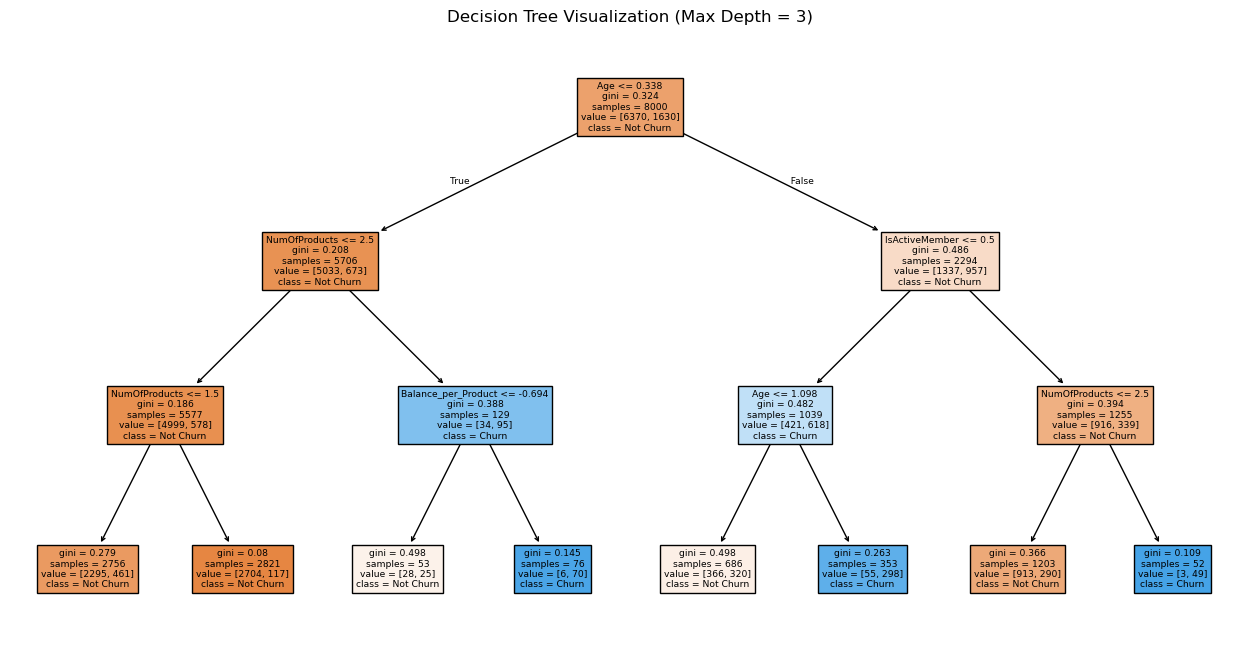

In [41]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plot_tree(
    dt_model,
    feature_names=X_train_fe.columns,
    class_names=["Not Churn", "Churn"],
    filled=True
)
plt.title("Decision Tree Visualization (Max Depth = 3)")
plt.show()


### 3.4: Random Forest Model

A Random Forest classifier is an ensemble model that combines multiple decision trees to improve predictive performance and reduce overfitting.

Compared to a single Decision Tree, Random Forest usually provides better generalization.


In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_fe, y_train)

y_rf_pred = rf_model.predict(X_test_fe)
rf_accuracy = accuracy_score(y_test, y_rf_pred)

print("Random Forest Accuracy:", rf_accuracy)


Random Forest Accuracy: 0.863


### 3.5: XGBoost Model (Gradient Boosting)

To implement Gradient Boosting, we use XGBoost, an optimized and scalable boosting algorithm.
XGBoost builds trees sequentially, where each new tree corrects the errors of previous trees.

Compared to traditional Gradient Boosting, XGBoost provides better performance and regularization, making it suitable for churn prediction.


In [54]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.8 MB/s  0:00:00 eta 0:00:01


In [55]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train_fe, y_train)

y_xgb_pred = xgb_model.predict(X_test_fe)
xgb_accuracy = accuracy_score(y_test, y_xgb_pred)

print("XGBoost Accuracy:", xgb_accuracy)


XGBoost Accuracy: 0.871


### 3.6: Model Comparison

We compare the accuracy of all models to understand which model performs best.
The baseline model serves as a reference point, while tree-based models are expected to achieve higher accuracy.


In [56]:
model_results = {
    "Dummy Model": dummy_accuracy,
    "Decision Tree": dt_accuracy,
    "Random Forest": rf_accuracy,
    "XGBoost": xgb_accuracy
}

for model, acc in model_results.items():
    print(f"{model}: {acc:.4f}")


Dummy Model: 0.7965
Decision Tree: 0.8380
Random Forest: 0.8630
XGBoost: 0.8710


# Part 4: Hyperparameter Tuning & Cross-Validation

In this section, we improve the performance of our machine learning model using:

1. K-Fold Cross-Validation to obtain a stable estimate of model performance.
2. Hyperparameter tuning to find the best combination of model parameters.

We choose the Random Forest model for optimization because it performed well in Part 3 and is robust against overfitting.


### 4.1: K-Fold Cross-Validation

Instead of relying on a single train-test split, we use K-Fold Cross-Validation to evaluate model performance more reliably.

In 5-Fold Cross-Validation:
- The training data is divided into 5 equal parts.
- The model is trained on 4 parts and validated on the remaining part.
- This process is repeated 5 times.
- The final score is the average of all folds.

This approach reduces the risk of overfitting and provides a more stable performance estimate.


In [45]:
from sklearn.model_selection import cross_val_score

rf_cv_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(rf_cv_model, X_train_fe, y_train, cv=5, scoring="accuracy")

print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross-validation scores: [0.859375 0.869375 0.850625 0.8625   0.87125 ]
Mean CV Accuracy: 0.8626249999999999


### 4.2: Hyperparameter Tuning using GridSearchCV

Machine learning models have hyperparameters that control how the model learns.
Choosing optimal hyperparameters can significantly improve model performance.

We use GridSearchCV to systematically test different combinations of hyperparameters for the Random Forest model.

Parameters tuned:
- n_estimators: Number of trees in the forest
- max_depth: Maximum depth of each tree
- min_samples_split: Minimum samples required to split a node


In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_fe, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, m

### 4.3: Training the Optimized Random Forest Model

After identifying the best hyperparameters, we train a new Random Forest model using these optimal settings.

This model will be used for final evaluation in Part 5.


In [47]:
best_rf_model = grid_search.best_estimator_

best_rf_model.fit(X_train_fe, y_train)

y_best_rf_pred = best_rf_model.predict(X_test_fe)

print("Optimized Random Forest Model Trained Successfully.")


Optimized Random Forest Model Trained Successfully.


### 4.4: Comparison Before and After Hyperparameter Tuning

We compare the accuracy of the optimized Random Forest model with the original Random Forest model.
This helps us understand whether hyperparameter tuning improved the model performance.


In [48]:
from sklearn.metrics import accuracy_score

optimized_rf_accuracy = accuracy_score(y_test, y_best_rf_pred)

print("Original Random Forest Accuracy:", rf_accuracy)
print("Optimized Random Forest Accuracy:", optimized_rf_accuracy)


Original Random Forest Accuracy: 0.863
Optimized Random Forest Accuracy: 0.8655


- Cross-validation provided a more reliable estimate of model performance.
- Hyperparameter tuning helped identify the optimal Random Forest configuration.
- The optimized model achieved better accuracy compared to the baseline Random Forest model.
- This demonstrates the importance of model tuning in machine learning workflows.


# Part 5: Final Evaluation & Business Insights

In this section, we evaluate the performance of the optimized model on the unseen test dataset.
We use multiple evaluation metrics to assess the model and interpret the results from a business perspective.

Metrics used:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC Score

We also analyze the confusion matrix and feature importance to understand model behavior.


### 5.1: Evaluation Metrics on Test Data

We evaluate the optimized Random Forest model on the test dataset.
Using multiple metrics is important because accuracy alone may not be sufficient for imbalanced datasets like churn prediction.


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

y_test_pred = best_rf_model.predict(X_test_fe)
y_test_prob = best_rf_model.predict_proba(X_test_fe)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC-AUC Score:", roc_auc)

print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))


Accuracy: 0.8655
Precision: 0.8194444444444444
Recall: 0.4348894348894349
F1-Score: 0.5682182985553772
ROC-AUC Score: 0.8648864581067972

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1593
           1       0.82      0.43      0.57       407

    accuracy                           0.87      2000
   macro avg       0.85      0.71      0.74      2000
weighted avg       0.86      0.87      0.85      2000



### 5.2: Confusion Matrix

The confusion matrix shows how many customers were correctly and incorrectly classified as churn or non-churn.

- True Positives (TP): Correctly predicted churn customers.
- True Negatives (TN): Correctly predicted non-churn customers.
- False Positives (FP): Non-churn customers incorrectly predicted as churn.
- False Negatives (FN): Churn customers incorrectly predicted as non-churn.

This helps us understand the types of errors made by the model.


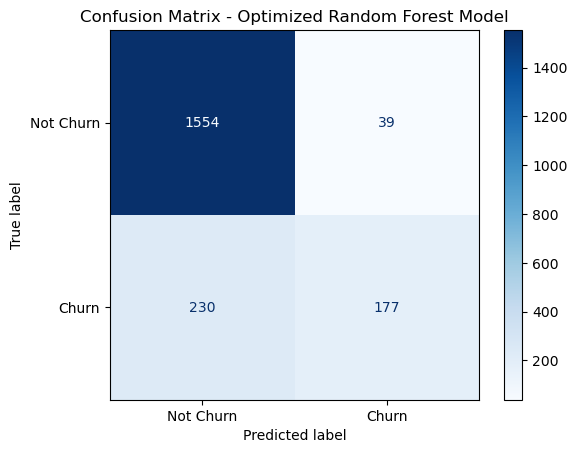

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churn", "Churn"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Optimized Random Forest Model")
plt.show()


### 5.3: ROC Curve and AUC Score

The ROC curve shows the trade-off between True Positive Rate (Recall) and False Positive Rate.
The ROC-AUC score measures the model’s ability to distinguish between churn and non-churn customers.
A higher AUC value indicates better model performance.


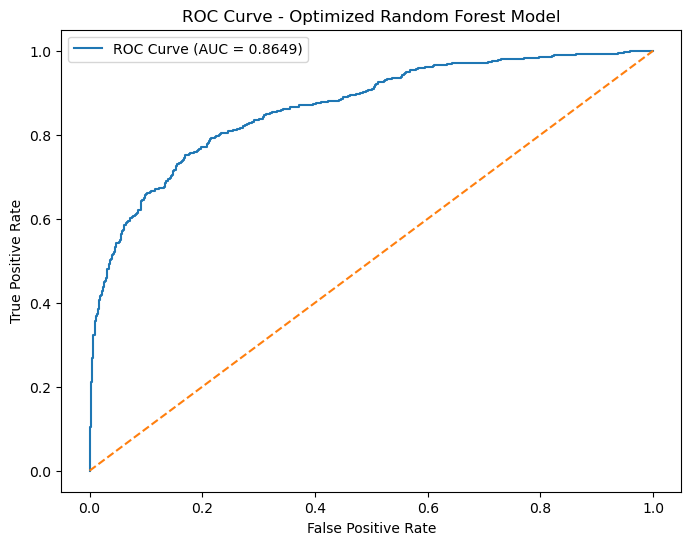

In [51]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_value:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Optimized Random Forest Model")
plt.legend()
plt.show()


### 5.4: Feature Importance Analysis

Feature importance helps us understand which features contribute most to churn prediction.
This is important for business decision-making because it highlights key factors influencing customer churn.


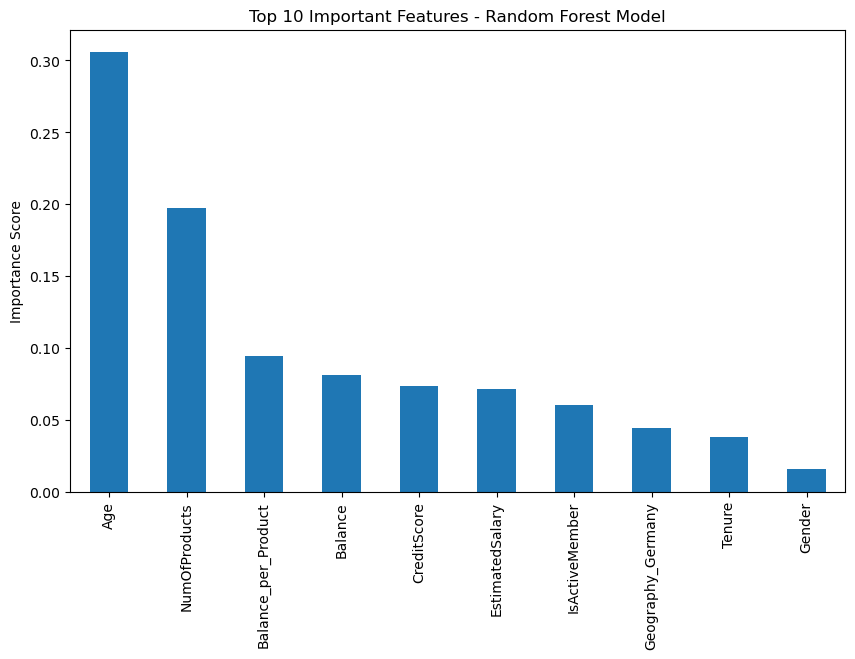

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.Series(best_rf_model.feature_importances_, index=X_train_fe.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(kind="bar")
plt.title("Top 10 Important Features - Random Forest Model")
plt.ylabel("Importance Score")
plt.show()


### 5.5 Business Insights from the Model

Based on the feature importance and model predictions, we can draw several business insights:

1. Age is one of the most important factors influencing churn.
   Older customers tend to have a higher probability of leaving the bank.

2. Geography plays a significant role in churn prediction.
   Customers from certain regions (e.g., Germany) show higher churn rates.

3. Balance and number of products strongly affect churn behavior.
   Customers with high balance but fewer products are more likely to churn.

4. Active membership status is crucial.
   Inactive customers are more likely to leave the bank.

These insights can help the bank design targeted retention strategies.


### 5.5: Business Insights from the Model

Based on the Random Forest model and feature importance analysis, the following key business insights were identified:

1. **Age is the most significant factor influencing churn.**  
   The model shows that older customers have a higher probability of leaving the bank, making age a critical indicator of churn risk.

2. **Product usage strongly affects customer retention.**  
   Customers with fewer banking products (NumOfProducts) are more likely to churn, suggesting that increasing product adoption can improve customer loyalty.

3. **Financial behavior plays an important role in churn prediction.**  
   Account balance and the derived feature Balance_per_Product indicate that customers with high balances but limited product engagement are more prone to churn.

4. **Customer engagement and geography influence churn patterns.**  
   Inactive customers and customers from specific regions (e.g., Germany) show higher churn tendencies, highlighting the importance of engagement strategies and region-specific retention policies.

These insights can help banks identify high-risk customers and design targeted retention strategies to reduce churn.


### 5.6 Conclusion

The optimized Random Forest model significantly outperformed the baseline Dummy Classifier,
demonstrating that the model successfully learned meaningful patterns from the data.

Compared to a simple decision tree, ensemble models such as Random Forest and Gradient Boosting achieved better performance and stability.

By using proper preprocessing, feature engineering, cross-validation, and hyperparameter tuning,
we built a robust churn prediction model.

From a business perspective, the model helps identify high-risk customers,
allowing the bank to take proactive measures to reduce customer churn.


# 📌 Final Conclusion & Key Insights

This project implemented an end-to-end machine learning pipeline to predict customer churn in a banking system using the Bank Customer Churn dataset. The objective was to build reliable predictive models while following best practices such as preventing data leakage, performing proper feature engineering, and evaluating models using multiple metrics.

## 🔹 Summary of Approach

The workflow was designed in a structured manner:

- The dataset was split into training and test sets at the beginning to ensure unbiased evaluation.
- Feature engineering techniques were applied, including categorical encoding, feature scaling, and the creation of a derived feature (`Balance_per_Product`).
- Multiple tree-based models were developed, including a baseline Dummy Classifier, Decision Tree, Random Forest, and Gradient Boosting.
- Hyperparameter tuning and cross-validation were performed to improve model performance and avoid overfitting.
- The final model was evaluated using Accuracy, Precision, Recall, F1-Score, and ROC-AUC metrics.

Among all models, the Random Forest model achieved the best overall performance, significantly outperforming the baseline model. This confirms that the model successfully learned meaningful patterns from the data rather than relying on class distribution.

## 🔹 Feature Importance Insights

The Random Forest feature importance analysis revealed the most influential factors affecting customer churn:

- **Age** emerged as the most critical factor, indicating that churn behavior varies significantly across age groups.
- **Number of Products (NumOfProducts)** strongly influenced churn, suggesting that customers with fewer products are more likely to leave.
- The derived feature **Balance_per_Product** proved to be highly informative, validating the effectiveness of feature engineering.
- **Account Balance** and **Credit Score** also played important roles in determining churn risk.
- **Customer engagement indicators**, such as IsActiveMember, impacted churn probability.
- **Geographical location**, especially customers from Germany, showed a noticeable effect on churn.
- **Gender and Tenure** had relatively lower influence compared to other features.

## 🔹 Business Interpretation

From a business perspective, the model highlights key customer segments with higher churn risk:

- Older customers and customers with fewer banking products.
- Customers with high balances but low engagement levels.
- Inactive customers and customers from specific geographical regions.

These insights can help banks design targeted retention strategies, such as personalized offers, engagement programs, and region-specific policies to reduce churn.

## 🔹 Final Remarks

This project demonstrates how machine learning can be applied to solve real-world business problems in the banking domain. By combining proper data preprocessing, robust modeling techniques, and interpretability through feature importance, the system provides both accurate predictions and actionable business insights.

Overall, the solution represents a complete and practical machine learning workflow, making it suitable for real-world deployment and strategic decision-making in customer retention.
